In [1]:
# Try to import vrplib and read external files; fallback to embedded copies if needed.
USE_VRPLIB = True
try:
    import vrplib  # pip install vrplib
except Exception as e:
    print("vrplib not available:", e)
    USE_VRPLIB = False

instance_a = vrplib.read_instance("data/A-n32-k5.vrp")

instance_b = vrplib.read_instance("data/B-n78-k10.vrp")

instance_x = vrplib.read_instance("data/X-n101-k25.vrp")

#Hemen 7 oct
VRP_FILES= instance_a, instance_b, instance_x

In [2]:
!pip install pandas

## Core Model & Utilities

In [3]:
class Solution:
    """
    Represents a solution (individual) in the population.
    """
    def __init__(self, x):
        self.x = x
        self.objectives = None
        self.rank = None
        self.crowding_distance = None


## VEGA (Vector Evaluated Genetic Algorithm)

In [4]:
import numpy as np
import random

# Adapted from assignment 1
def create_individual(instance, n_vehicles):
    """
    Create a random solution/individual for the CVRP instance.
    
    An individual consists of:
    - schedule: a permutation of all customer indices (excluding the depot)
    - vehicles_assigned: a list assigning each customer to a vehicle
    
    :param instance: CVRP instance dictionary containing node coordinates and depot info
    :param n_vehicles: number of vehicles available
    
    :return: individual/solution as a list [schedule, vehicles_assigned]
    """
    # Get index of the depot - routes start and end in depot, depot not included in solution
    depot_idx = instance['depot'][0]

    # Excluding depot to get the customer indices (the other locations)
    customer_indices = [i for i in range(len(instance['node_coord'])) if i != depot_idx]

    # Randomly create schedule and assign vehicles
    schedule = random.sample(customer_indices, len(customer_indices))
    vehicles_assigned = np.random.randint(0, n_vehicles, size=len(customer_indices)).tolist()
    individual = [schedule, vehicles_assigned]

    return individual    


#Hemen 7 oct


## Main algorithm2


In [5]:
# Adapted from assignment 1

def get_distance(route, instance):
    """
    Calculate the distance of the route of one vehicle, including leaving and returning to depot.

    :param route: List of customer indices in visit order
    :param instance: CVRP instance dictionary with 'depot' and 'edge_weight'
    
    :return: Distance of the route
    """
    
    # Get index of the depot and add it to full route to calculate total distance
    depot_idx = instance['depot'][0]
    full_route = [depot_idx] + route + [depot_idx]
    edge_weight = instance["edge_weight"]

    
    route_distance = 0
    # Add distances from the distance matrix contained by the instance dictionary
    for i in range(len(full_route)-1):
        route_distance += edge_weight[full_route[i], full_route[i+1]]
        
    return route_distance



def total_distance(individual, instance, n_vehicles):
    """
    Compute the total distance for all routes of an individual/solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles
    
    :return: Sum of distances of all routes
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)
        
    total_distance = 0 

    # Sum the distances for each vehicle route
    for route in routes:
        total_distance += get_distance(route, instance)
        
    return total_distance
    
def route_balance_std(individual, instance, n_vehicles):
    """
    Compute the route balance metric - Standard Deviation of Route Lengths
    for a given individual/ solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles

    :return: Standard Deviation of Route Lengths
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)

    # Append distances for each vehicle route and compute standard deviation
    route_lengths = []

    for route in routes:
        route_lengths.append(get_distance(route, instance))


    route_balance_std = np.std(route_lengths)
    return route_balance_std

In [6]:
# CROSSOVER

# Solution/ individual: [[schedule, vehicles assigned]]
# Schedule -> Permutation of customer idx
# Vehicles assigned -> Integers

# individual: [[route][vehicles]]
# [route] -> Permutation
# [vehicles] -> INTEGERS

# parents crossover: crossover for routes + crossover for vehicles

from random import randint, uniform, shuffle


def pmx(parent1, parent2, start, end):
    """
    Partially Mapped Crossover (PMX) for permutations.

    :param parent1: parent permutation (customer indices)
    :param parent2: parent permutation (customer indices)

    :return: one child resulting from PMX
    
    """
    
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]

    for ind, x in enumerate(parent2[start:end]):
        ind += start
        if x not in child:
            while child[ind] != None:
                ind = parent2.index(parent1[ind])
            child[ind] = x

    for ind, x in enumerate(child):
        if x == None:
            child[ind] = parent2[ind]

    return child



# Uniform crossover for vehicles
# each gene is treated independently
# for each gene, choosing randomly from which parent to take the genes from
def uniform_crossover(vehicles1, vehicles2):
    """
    Uniform crossover for vehicle assignments.
    Each gene is treated independently.
    For each gene, choosing randomly from which parent to take the genes from.

    :param vehicles1: vehicle assignment list
    :param vehicles2: vehicle assignment list

    :returns: two children vehicle assignments
    """

    
    child1 = []
    child2 = []

    # For each gene, choosing randomly from which parents to inherit 
    for v1, v2 in zip(vehicles1, vehicles2):
        
        if random.random() < 0.5:
            child1.append(v1)
            child2.append(v2)
            
        else:
            child2.append(v1)
            child1.append(v2)   
            
    return child1, child2
        



def crossover_(parent1, parent2):
    """
    Performing crossover on two individuals/solutions.

    :param parent1: a Solution object
    :param parent2: a Solution object

    :returns: two children Solution objects
    """

    
    # Extract schedule and vehicles from Solution objects
    p1_schedule, p1_vehicles = parent1.x
    p2_schedule, p2_vehicles = parent2.x

    
    # Apply PMX for schedules (permutations)
    half = len(p1_schedule)//2
    start = randint(0, len(p1_schedule)-half)
    end = start + half
    child_route1 = pmx(p1_schedule, p2_schedule, start, end)
    child_route2 = pmx(p2_schedule, p1_schedule, start, end)

    # Apply uniform crossover for vehicles assignments (lists of integers)
    child_vehicles1, child_vehicles2 = uniform_crossover(p1_vehicles, p2_vehicles)

    # Create children Solution objects 
    child1 = Solution([child_route1, child_vehicles1])
    child2 = Solution([child_route2, child_vehicles2])

    return child1, child2


## Experiment Harness (VEGA only)

In [7]:
# MUTATION
# Solution/ individual: [[schedule, vehicles assigned]]
# Schedule -> Permutation of customer idx
# Vehicles assigned -> Integers
# MUTATION CAN BE route mutation or vehicles mutation

def mutate_routes(route):
    """
    Randomly mutates a route by scrambling a segment of the route.

    :param route: list of customer idx

    :return: mutated route
    """
    if len(route) < 2:
        return route

    # Select and scramble segment
    start, end = sorted(random.sample(range(len(route)), 2))
    segment = route[start:end+1]
    random.shuffle(segment)
    
    # Create new route
    new_route = route[:start] + segment + route[end+1:]
    
    return new_route


# function for vehicles mutation
# random resetting
# in each position, with a probability
# replace with a new vehicle value 
# from the list of admissible values

def mutate_vehicles(vehicles, mutation_prob, n_vehicles):
    """
    Mutates assigned vehicles with random resetting.
    In each position, with a probability, replace 
    with a new vehicle value, 
    from the list of admissible values.

    :param vehicles: list of assigned vehicles (integers)
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles


    return: mutated vehicles assignment
    """
    
    mutated = vehicles.copy()
    
    for i in range(len(mutated)):
        if random.random() < mutation_prob:
            old_v = vehicles[i]
            mutated[i] = random.choice([v for v in range(n_vehicles) if v != old_v])
            
    return mutated

def pick_mutation(individual, mutation_prob, n_vehicles):
    """
    Decide which part of individual (schedule or 
    assigned vehicles) to mutate.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles

    :return mutated individual
    
    """
    
    route, vehicles = individual[0], individual[1]
    
    if random.random() < 0.5:
        route = mutate_routes(route)
    
    else:
        vehicles = mutate_vehicles(vehicles, mutation_prob, n_vehicles)
        
    return [route, vehicles]


def mutate(individual, mutation_prob, n_vehicles):
    """
    Decides if individual is mutated.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles
    
    :return mutated individual or original individual
    """
    
    if random.random() < mutation_prob:
        mutated = pick_mutation(individual, mutation_prob, n_vehicles)
        return mutated
        
    return individual
 
 

## Analysis & Plots

## Quick Smoke Test

In [8]:
!pip install vrplib

In [9]:
### number of vehicles is given by the instance name

n_vehicles_a = 5
n_vehicles_b = 10
n_vehicles_x = 25

# source: https://vrp.atd-lab.inf.puc-rio.br/index.php/en/

import vrplib


instance_a = vrplib.read_instance("data/A-n32-k5.vrp")

instance_b = vrplib.read_instance("data/B-n78-k10.vrp")

instance_x = vrplib.read_instance("data/X-n101-k25.vrp")





###


## Full Study (≥ 20 runs)

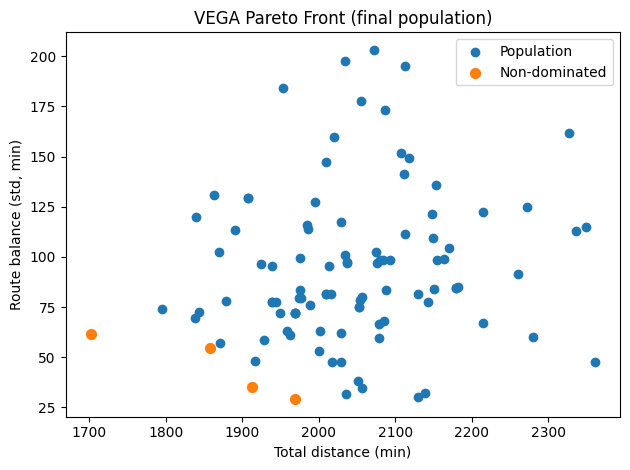

Saved figure to vega_pareto.png


In [ ]:
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

class VEGA:
    """
    Vector Evaluated Genetic Algorithm (VEGA) implementation.
    This class implements VEGA for solving multi-objective optimization problems.
    """

    def __init__(self, pop_size: int, num_objectives: int,instance, n_vehicles: int, 
                 crossover_rate: float, mutation_rate: float, objective_functions,):
        """
        Initialize the VEGA.

        Args:
            pop_size (int): Size of the population. Should be divisible by num_objectives.
            num_objectives (int): Number of objectives to optimize.
            gene_size (int): Number of genes in each individual.
            crossover_rate (float): Probability of crossover occurring.
            mutation_rate (float): Probability of mutation for each gene.
        """
        assert pop_size % num_objectives == 0, "Population size should be divisible by number of objectives"
        self.pop_size = pop_size
        self.num_objectives = num_objectives
        self.subpop_size = pop_size // num_objectives
        self.instance = instance
        self.objective_functions = objective_functions
        self.n_vehicles = n_vehicles
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()

    def initialize_population(self):
        """
        Generate an initial population of random solutions of size self.pop_size.
        """
        return [Solution(create_individual(self.instance, self.n_vehicles)) for _ in range(self.pop_size)]

    def evaluate_fitness(self, population):
        """
        Evaluate the objective functions for each solution in the population.

        :param population: List of Solution objects
        :return: numpy array of shape (pop_size, num_objectives)
        """
        fitness_values = []
        for solution in population:
            solution.objectives = [f(solution.x, self.instance, self.n_vehicles) for f in self.objective_functions]
            fitness_values.append(solution.objectives)
        return np.array(fitness_values)

    def vega_selection(self, fitness_values: np.ndarray) -> list:
        """
        Perform VEGA selection by creating sub-populations based on each objective.

        Args:
            fitness_values (np.ndarray): Fitness values for the entire population.

        Returns:
            list: Combined selected individuals from all sub-populations.
        """
        selected_indices = []

        for obj in range(self.num_objectives):
            # Sort based on the current objective
            obj_indices = np.argsort(fitness_values[:, obj])[:self.subpop_size]
            selected_indices.extend(obj_indices)

        return [self.population[i] for i in selected_indices]

    def crossover(self, parent1, parent2):
        """
        Decides if crossover between two parents is performed.
        
        :param parent1: Solution object
        :param parent2: Solution object
        
        :return: Two offspring or original parents
        """
        if np.random.random() < self.crossover_rate:
            child1, child2 = crossover_(parent1, parent2)
            return child1, child2
        return parent1, parent2

    def mutation(self, solution):
        """
        Apply mutation to a Solution object.

        :param solution: Solution object
        :return: mutated Solution object
        """
        solution.x = mutate(solution.x, self.mutation_rate, self.n_vehicles)
        return solution

    def run(self, generations: int) -> list:
        """
        Run the VEGA for a specified number of generations.

        Args:
            generations (int): Number of generations to run.

        Returns:
            list: The final population (list of Solution objects).
        """
        for _ in range(generations):
            # Evaluate fitness for the whole population and collect objectives
            fitness_values = self.evaluate_fitness(self.population)
            
            # Perform VEGA selection
            selected_population = self.vega_selection(fitness_values)
            
            # Create new population through crossover and mutation
            new_population = []
            while len(new_population) < self.pop_size:
                parent_indices = np.random.choice(len(selected_population), 2, replace=False)
                parent1, parent2 = selected_population[parent_indices[0]], selected_population[parent_indices[1]]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                new_population.append(child1)
                if len(new_population) < self.pop_size:
                    new_population.append(child2)
            self.population = new_population
        # Ensure objectives are set for the final population
        self.evaluate_fitness(self.population)
        return self.population

# Usage example
vega = VEGA(pop_size=100, num_objectives=2, instance=instance_a,n_vehicles=n_vehicles_a,objective_functions=[total_distance,route_balance_std], crossover_rate=0.8, mutation_rate=0.1)
final_population = vega.run(generations=50)

def extract_objectives(population):
    """
    Returns a (N, M) numpy array of objective values from a list of Solution objects.
    Assumes each Solution has `objectives` populated (length = num_objectives).
    """
    return np.array([np.asarray(sol.objectives, dtype=float) for sol in population])

def nondominated_mask(objs):
    """
    Compute a boolean mask of nondominated points for MINIMIZATION objectives.
    objs: (N, M) array.
    """
    N = objs.shape[0]
    mask = np.ones(N, dtype=bool)
    for i in range(N):
        if not mask[i]:
            continue
        # any j that strictly dominates i?
        dominates_i = np.all(objs <= objs[i], axis=1) & np.any(objs < objs[i], axis=1)
        dominates_i[i] = False
        if np.any(dominates_i):
            mask[i] = False
    return mask

def plot_vega_pareto(final_population, objective_labels=("f1", "f2"), title="VEGA Pareto Front"):
    """
    Plots all points and the nondominated subset.
    - Uses a single figure (as required).
    - Does not set explicit colors or styles.
    - Saves the figure to 'vega_pareto.png'.
    """
    objs = extract_objectives(final_population)
    if objs.ndim != 2 or objs.shape[1] < 2:
        raise ValueError("Expected at least 2 objectives per solution to plot a Pareto front.")

    nd_mask = nondominated_mask(objs)
    nd = objs[nd_mask]
    rest = objs[~nd_mask]

    plt.figure()
    if rest.size:
        plt.scatter(rest[:, 0], rest[:, 1], label="Population")
    plt.scatter(nd[:, 0], nd[:, 1], label="Non-dominated", s=50)  # slightly larger markers

    plt.xlabel(objective_labels[0] if len(objective_labels) > 0 else "Objective 1")
    plt.ylabel(objective_labels[1] if len(objective_labels) > 1 else "Objective 2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig("vega_pareto.png", dpi=150)
    plt.show()

# Example usage (after your VEGA run):
# final_population = vega.run(generations=50)
plot_vega_pareto(
    final_population,
    objective_labels=("Total distance (min)", "Route balance (std, min)"),
    title="VEGA Pareto Front (final population)"
)
print("Saved figure to vega_pareto.png")



In [ ]:
### number of vehicles is given by the instance name

# SMALL
n_vehicles_a = 5
n_vehicles_a_2 = 5

# MEDIUM
n_vehicles_b = 10
n_vehicles_b_2 = 10

# LARGE
n_vehicles_x = 25
n_vehicles_x_2 = 46

# source: https://vrp.atd-lab.inf.puc-rio.br/index.php/en/

import vrplib

# SMALL
instance_a = vrplib.read_instance("data/A-n32-k5.vrp")
instance_a_2 = vrplib.read_instance("data/A-n37-k5.vrp")


#MEDIUM
instance_b = vrplib.read_instance("data/B-n78-k10.vrp")
instance_b_2 = vrplib.read_instance("data/B-n63-k10.vrp")


# LARGE
instance_x = vrplib.read_instance("data/X-n101-k25.vrp")
instance_x_2 = vrplib.read_instance("data/X-n148-k46.vrp")

Total combined solutions: 181
Total Distance and Route Balance
Min Total Distance: 1269.32, Min Route Balance: 9.26
Mean Total Distance: 1736.62, Mean Route Balance: 53.25
Range of Total Distance and Range of Route Balance
Range Total Distance: 900.81, Range Route Balance: 149.80


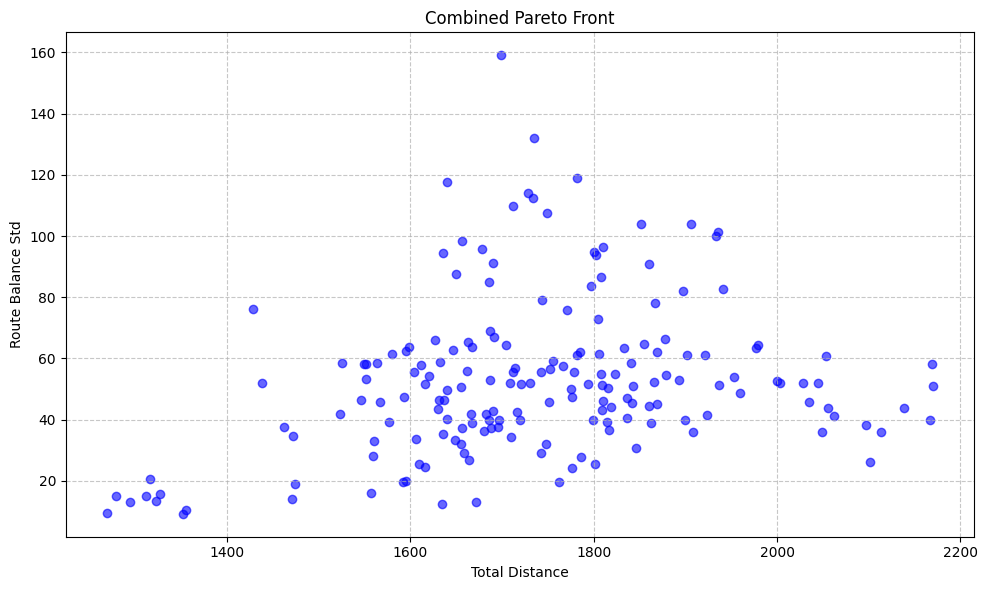

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a, n_vehicles=n_vehicles_a, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.7, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a, n_vehicles=n_vehicles_a, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.3):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a, n_vehicles=n_vehicles_a, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a_2, n_vehicles=n_vehicles_a_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.7, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a_2, n_vehicles=n_vehicles_a_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.3):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a_2, n_vehicles=n_vehicles_a_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=70, n_generations=70,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b, n_vehicles=n_vehicles_b, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=70,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b, n_vehicles=n_vehicles_b, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=70, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b, n_vehicles=n_vehicles_b, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=70, n_generations=70,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b_2, n_vehicles=n_vehicles_b_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=70,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b_2, n_vehicles=n_vehicles_b_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=70, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b_2, n_vehicles=n_vehicles_b_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=90, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x, n_vehicles=n_vehicles_x, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=100, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x, n_vehicles=n_vehicles_x, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=90, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.01):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x, n_vehicles=n_vehicles_x, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=90, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x_2, n_vehicles=n_vehicles_x_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=100, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x_2, n_vehicles=n_vehicles_x_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=90, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.01):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x_2, n_vehicles=n_vehicles_x_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

VEGA with feasability

In [16]:
class Solution:
    """
    Represents a solution (individual) in the population.
    """
    def __init__(self, x):
        self.x = x
        self.objectives = None
        self.rank = None
        self.crowding_distance = None
        ## Violation - How much the solution exceeds vehicle capacities
        self.violation = None

In [17]:
def is_feasible(individual, instance, n_vehicles):
    """
    Checks if Individual is feasible -> Does not exceed capacity constraints.
    
    An individual consists of:
    - schedule: a permutation of all customer indices (excluding the depot)
    - vehicles_assigned: a list assigning each customer to a vehicle
    
    :param instance: CVRP instance dictionary containing node coordinates and depot info
    :param n_vehicles: number of vehicles available
    
    :return: True, if all vehicles stay within capacity constraints; False, otherwise
    """
    
    schedule, vehicles = individual
    capacity = instance["capacity"]
    demand = instance["demand"][1:]

    vehicle_loads = [0] * n_vehicles
    for cust_id, vehicle in zip(schedule, vehicles):
        vehicle_loads[vehicle] += demand[cust_id - 1]
    
    # Feasible if all loads <= capacity
    return all(load <= capacity for load in vehicle_loads)

In [18]:
import numpy as np
import random

# Adapted from assignment 1
def create_individual(instance, n_vehicles):
    """
    Create a random solution/individual for the CVRP instance.
    
    An individual consists of:
    - schedule: a permutation of all customer indices (excluding the depot)
    - vehicles_assigned: a list assigning each customer to a vehicle
    
    :param instance: CVRP instance dictionary containing node coordinates and depot info
    :param n_vehicles: number of vehicles available
    
    :return: individual/solution as a list [schedule, vehicles_assigned]
    """
    # Get index of the depot - routes start and end in depot, depot not included in solution
    depot_idx = instance['depot'][0]

    # Excluding depot to get the customer indices (the other locations)
    customer_indices = [i for i in range(len(instance['node_coord'])) if i != depot_idx]

    # Randomly create schedule and assign vehicles
    schedule = random.sample(customer_indices, len(customer_indices))
    vehicles_assigned = np.random.randint(0, n_vehicles, size=len(customer_indices)).tolist()
    individual = [schedule, vehicles_assigned]
    ## If not feasible, try to repair
    if not is_feasible(individual, instance, n_vehicles):
        individual = vehicle_capacity_repair(individual, instance, n_vehicles, max_iters=50)

    return individual

In [19]:
import copy
import random


# inspired by https://transport-systems.imperial.ac.uk/tf/60008_21/n6_10_vehicle_routing_problem-genetic_algorithm.html

def vehicle_capacity_repair(individual, instance, n_vehicles, max_iters=50):
    """
    Repairs an individual (schedule + vehicle assignments) to respect vehicle capacity, 
    by moving customers to different vehicles.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles
    :param max_iters: maximum iterations to try repairing

    :return: repaired individual with no vehicle exceeding capacity if possible

    

    Parameters:
    - individual: [schedule, vehicles], the VRP solution
    - instance: CVRP instance containing capacity and demand
    - n_vehicles: number of vehicles
    - max_iters: maximum iterations to try repairing

    Returns:
    - repaired individual: [schedule, vehicles] with no vehicle exceeding capacity (if possible)
    """
    
    schedule, vehicles = copy.deepcopy(individual)

    
    capacity = instance["capacity"]
    demand = instance["demand"][1:]

    vehicle_loads = [0]*n_vehicles
    for cust_id, vehicle in zip(schedule, vehicles):
        vehicle_loads[vehicle] += demand[cust_id-1]

    #print("Initial Loads:", vehicle_loads)
    excess_load = [capacity - load for load in vehicle_loads]

    iters = 0
    
    while any(e < 0 for e in excess_load) and iters < max_iters:
        iters += 1
        v_id = next(i for i, e in enumerate(excess_load) if e < 0)
        idx_customers = [i for i, v in enumerate(vehicles) if v == v_id]
        moved = False

        for idx_to_move in random.sample(idx_customers, len(idx_customers)):
            cust_id = schedule[idx_to_move]
            demand_to_move = demand[cust_id-1]

            fit_vehicles = [i for i, e in enumerate(excess_load) if e >= demand_to_move and i != v_id]
            if not fit_vehicles:
                continue

            to_vehicle = random.choice(fit_vehicles)
            vehicles[idx_to_move] = to_vehicle
            excess_load[v_id] += demand_to_move
            excess_load[to_vehicle] -= demand_to_move
            moved = True
            #print(f"Moved customer {cust_id} from vehicle {v_id} to {to_vehicle}")
            break

        if not moved:
            #print("Cannot repair further: no customer can fit any vehicle")
            break

    # Final loads
    vehicle_loads = [0]*n_vehicles
    for cust_id, vehicle in zip(schedule, vehicles):
        vehicle_loads[vehicle] += demand[cust_id-1]

    #print("Final Loads after repair:", vehicle_loads)
    return [schedule, vehicles]

In [20]:
# Adapted from assignment 1

def get_distance(route, instance):
    """
    Calculate the distance of the route of one vehicle, including leaving and returning to depot.

    :param route: List of customer indices in visit order
    :param instance: CVRP instance dictionary with 'depot' and 'edge_weight'
    
    :return: Distance of the route
    """
    
    # Get index of the depot and add it to full route to calculate total distance
    depot_idx = instance['depot'][0]
    full_route = [depot_idx] + route + [depot_idx]
    edge_weight = instance["edge_weight"]

    
    route_distance = 0
    # Add distances from the distance matrix contained by the instance dictionary
    for i in range(len(full_route)-1):
        route_distance += edge_weight[full_route[i], full_route[i+1]]
        
    return route_distance

def total_distance(individual, instance, n_vehicles):
    """
    Compute the total distance for all routes of an individual/solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles
    
    :return: Sum of distances of all routes
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)
        
    total_distance = 0 

    # Sum the distances for each vehicle route
    for route in routes:
        total_distance += get_distance(route, instance)
        
    return total_distance
    
def route_balance_std(individual, instance, n_vehicles):
    """
    Compute the route balance metric - Standard Deviation of Route Lengths
    for a given individual/ solution.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles

    :return: Standard Deviation of Route Lengths
    """

    # Assign customers to each vehicle route
    routes = [[] for i in range(n_vehicles)]
    for s,v in zip(individual[0], individual[1]):
        routes[v].append(s)

    # Append distances for each vehicle route and compute standard deviation
    route_lengths = []

    for route in routes:
        route_lengths.append(get_distance(route, instance))


    route_balance_std = np.std(route_lengths)
    return route_balance_std

In [21]:
# CROSSOVER

# Solution/ individual: [[schedule, vehicles assigned]]
# Schedule -> Permutation of customer idx
# Vehicles assigned -> Integers

# individual: [[route][vehicles]]
# [route] -> Permutation
# [vehicles] -> INTEGERS

# parents crossover: crossover for routes + crossover for vehicles

from random import randint, uniform, shuffle


def pmx(parent1, parent2, start, end):
    """
    Partially Mapped Crossover (PMX) for permutations.

    :param parent1: parent permutation (customer indices)
    :param parent2: parent permutation (customer indices)

    :return: one child resulting from PMX
    
    """
    
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]

    for ind, x in enumerate(parent2[start:end]):
        ind += start
        if x not in child:
            while child[ind] != None:
                ind = parent2.index(parent1[ind])
            child[ind] = x

    for ind, x in enumerate(child):
        if x == None:
            child[ind] = parent2[ind]

    return child



# Uniform crossover for vehicles
# each gene is treated independently
# for each gene, choosing randomly from which parent to take the genes from
def uniform_crossover(vehicles1, vehicles2):
    """
    Uniform crossover for vehicle assignments.
    Each gene is treated independently.
    For each gene, choosing randomly from which parent to take the genes from.

    :param vehicles1: vehicle assignment list
    :param vehicles2: vehicle assignment list

    :returns: two children vehicle assignments
    """
    child1 = []
    child2 = []

    # For each gene, choosing randomly from which parents to inherit 
    for v1, v2 in zip(vehicles1, vehicles2):
        
        if random.random() < 0.5:
            child1.append(v1)
            child2.append(v2)
            
        else:
            child2.append(v1)
            child1.append(v2)   
            
    return child1, child2
        



def crossover_(parent1, parent2):
    """
    Performing crossover on two individuals/solutions.

    :param parent1: a Solution object
    :param parent2: a Solution object

    :returns: two children Solution objects
    """

    
    # Extract schedule and vehicles from Solution objects
    p1_schedule, p1_vehicles = parent1.x
    p2_schedule, p2_vehicles = parent2.x

    
    # Apply PMX for schedules (permutations)
    half = len(p1_schedule)//2
    start = randint(0, len(p1_schedule)-half)
    end = start + half
    child_route1 = pmx(p1_schedule, p2_schedule, start, end)
    child_route2 = pmx(p2_schedule, p1_schedule, start, end)

    # Apply uniform crossover for vehicles assignments (lists of integers)
    child_vehicles1, child_vehicles2 = uniform_crossover(p1_vehicles, p2_vehicles)

    # Create children Solution objects 
    child1 = Solution([child_route1, child_vehicles1])
    child2 = Solution([child_route2, child_vehicles2])

    return child1, child2

In [22]:
# MUTATION
# Solution/ individual: [[schedule, vehicles assigned]]
# Schedule -> Permutation of customer idx
# Vehicles assigned -> Integers
# MUTATION CAN BE route mutation or vehicles mutation

def mutate_routes(route):
    """
    Randomly mutates a route by scrambling a segment of the route.

    :param route: list of customer idx

    :return: mutated route
    """
    if len(route) < 2:
        return route

    # Select and scramble segment
    start, end = sorted(random.sample(range(len(route)), 2))
    segment = route[start:end+1]
    random.shuffle(segment)
    
    # Create new route
    new_route = route[:start] + segment + route[end+1:]
    
    return new_route


# function for vehicles mutation
# random resetting
# in each position, with a probability
# replace with a new vehicle value 
# from the list of admissible values

def mutate_vehicles(vehicles, mutation_prob, n_vehicles):
    """
    Mutates assigned vehicles with random resetting.
    In each position, with a probability, replace 
    with a new vehicle value, 
    from the list of admissible values.

    :param vehicles: list of assigned vehicles (integers)
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles


    return: mutated vehicles assignment
    """
    
    mutated = vehicles.copy()
    
    for i in range(len(mutated)):
        if random.random() < mutation_prob:
            old_v = vehicles[i]
            mutated[i] = random.choice([v for v in range(n_vehicles) if v != old_v])
            
    return mutated

def pick_mutation(individual, mutation_prob, n_vehicles):
    """
    Decide which part of individual (schedule or 
    assigned vehicles) to mutate.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles

    :return mutated individual
    
    """
    
    route, vehicles = individual[0], individual[1]
    
    if random.random() < 0.5:
        route = mutate_routes(route)
    
    else:
        vehicles = mutate_vehicles(vehicles, mutation_prob, n_vehicles)
        
    return [route, vehicles]


def mutate(individual, mutation_prob, n_vehicles):
    """
    Decides if individual is mutated.

    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule
    :param mutation_prob: probability value (between 0 and 1)
    :param n_vehicles: Number of vehicles
    
    :return mutated individual or original individual
    """
    
    if random.random() < mutation_prob:
        mutated = pick_mutation(individual, mutation_prob, n_vehicles)
        return mutated
        
    return individual

In [23]:
import copy

def compute_capacity_violation(individual, instance, n_vehicles):
    """
    Compute total violation of capacity (sum of overloads across vehicles)
    :param individual: [schedule, vehicles_assigned],
        where 
        schedule is a list of customer indices,
        vehicles is a list of vehicle assigments for customers in schedule

    :param instance: CVRP instance dictionary
    :param n_vehicles: Number of vehicles
    """
    schedule, vehicles = copy.deepcopy(individual)

    capacity = instance["capacity"]
    demand = instance["demand"][1:]  # exclude depot (index 0)

    # accumulate loads per vehicle
    vehicle_loads = [0] * n_vehicles
    for cust_id, vehicle in zip(schedule, vehicles):
        vehicle_loads[vehicle] += demand[cust_id - 1]  # customer ids start from 1

    # sum of all overloads (each route exceeding capacity)
    total_violation = sum(max(0, load - capacity) for load in vehicle_loads)

    return total_violation  # 0 if feasible

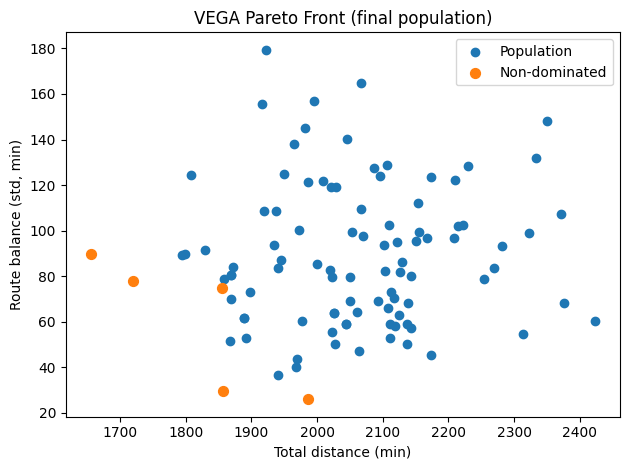

Saved figure to vega_pareto.png


In [24]:
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

class VEGA:
    """
    Vector Evaluated Genetic Algorithm (VEGA) implementation.
    This class implements VEGA for solving multi-objective optimization problems.
    """

    def __init__(self, pop_size: int, num_objectives: int,instance, n_vehicles: int, 
                 crossover_rate: float, mutation_rate: float, objective_functions,):
        """
        Initialize the VEGA.

        Args:
            pop_size (int): Size of the population. Should be divisible by num_objectives.
            num_objectives (int): Number of objectives to optimize.
            gene_size (int): Number of genes in each individual.
            crossover_rate (float): Probability of crossover occurring.
            mutation_rate (float): Probability of mutation for each gene.
        """
        assert pop_size % num_objectives == 0, "Population size should be divisible by number of objectives"
        self.pop_size = pop_size
        self.num_objectives = num_objectives
        self.subpop_size = pop_size // num_objectives
        self.instance = instance
        self.objective_functions = objective_functions
        self.n_vehicles = n_vehicles
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()

    def initialize_population(self):
        """
        Generate an initial population of random solutions of size self.pop_size.
        """
        return [Solution(create_individual(self.instance, self.n_vehicles)) for _ in range(self.pop_size)]

    def evaluate_fitness(self, population):
        """
        Evaluate the objective functions for each solution in the population.
        Apply a large penalty to objectives for infeasible individuals.

        :param population: List of Solution objects
        :return: numpy array of shape (pop_size, num_objectives)
        """
        fitness_values = []
        PENALTY = 1e6
        for solution in population:
            if is_feasible(solution.x, self.instance, self.n_vehicles):
                solution.objectives = [f(solution.x, self.instance, self.n_vehicles) for f in self.objective_functions]
            else:
                # Apply a large penalty to all objectives
                solution.objectives = [PENALTY for _ in self.objective_functions]
            fitness_values.append(solution.objectives)
        return np.array(fitness_values)

    def vega_selection(self, fitness_values: np.ndarray) -> list:
        """
        Perform VEGA selection by creating sub-populations based on each objective.

        Args:
            fitness_values (np.ndarray): Fitness values for the entire population.

        Returns:
            list: Combined selected individuals from all sub-populations.
        """
        selected_indices = []

        for obj in range(self.num_objectives):
            # Sort based on the current objective
            obj_indices = np.argsort(fitness_values[:, obj])[:self.subpop_size]
            selected_indices.extend(obj_indices)

        return [self.population[i] for i in selected_indices]

    def crossover(self, parent1, parent2):
        """
        Decides if crossover between two parents is performed.
        
        :param parent1: Solution object
        :param parent2: Solution object
        
        :return: Two offspring or original parents
        """
        if np.random.random() < self.crossover_rate:
            child1, child2 = crossover_(parent1, parent2)
            return child1, child2
        return parent1, parent2

    def mutation(self, solution):
        """
        Apply mutation to a Solution object.

        :param solution: Solution object
        :return: mutated Solution object
        """
        solution.x = mutate(solution.x, self.mutation_rate, self.n_vehicles)
        return solution

    def run(self, generations: int) -> list:
        """
        Run the VEGA for a specified number of generations.

        Args:
            generations (int): Number of generations to run.

        Returns:
            list: The final population (list of Solution objects).
        """
        for _ in range(generations):
            # Evaluate fitness for the whole population and collect objectives
            fitness_values = self.evaluate_fitness(self.population)
            
            # Perform VEGA selection
            selected_population = self.vega_selection(fitness_values)
            
            # Create new population through crossover and mutation
            new_population = []
            while len(new_population) < self.pop_size:
                parent_indices = np.random.choice(len(selected_population), 2, replace=False)
                parent1, parent2 = selected_population[parent_indices[0]], selected_population[parent_indices[1]]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                if not is_feasible(child1.x, self.instance, self.n_vehicles):
                    child1.x = vehicle_capacity_repair(child1.x, self.instance, self.n_vehicles, max_iters=50)
                if not is_feasible(child2.x, self.instance, self.n_vehicles):
                    child2.x = vehicle_capacity_repair(child2.x, self.instance, self.n_vehicles, max_iters=50)
                new_population.append(child1)
                if len(new_population) < self.pop_size:
                    new_population.append(child2)
            self.population = new_population
        # Ensure objectives are set for the final population
        self.evaluate_fitness(self.population)
        return self.population

# Usage example
vega = VEGA(pop_size=100, num_objectives=2, instance=instance_a,n_vehicles=n_vehicles_a,objective_functions=[total_distance,route_balance_std], crossover_rate=0.8, mutation_rate=0.1)
final_population = vega.run(generations=50)

def extract_objectives(population):
    """
    Returns a (N, M) numpy array of objective values from a list of Solution objects.
    Assumes each Solution has `objectives` populated (length = num_objectives).
    """
    return np.array([np.asarray(sol.objectives, dtype=float) for sol in population])

def nondominated_mask(objs):
    """
    Compute a boolean mask of nondominated points for MINIMIZATION objectives.
    objs: (N, M) array.
    """
    N = objs.shape[0]
    mask = np.ones(N, dtype=bool)
    for i in range(N):
        if not mask[i]:
            continue
        # any j that strictly dominates i?
        dominates_i = np.all(objs <= objs[i], axis=1) & np.any(objs < objs[i], axis=1)
        dominates_i[i] = False
        if np.any(dominates_i):
            mask[i] = False
    return mask

def plot_vega_pareto(final_population, objective_labels=("f1", "f2"), title="VEGA Pareto Front"):
    """
    Plots all points and the nondominated subset.
    - Uses a single figure (as required).
    - Does not set explicit colors or styles.
    - Saves the figure to 'vega_pareto.png'.
    """
    objs = extract_objectives(final_population)
    if objs.ndim != 2 or objs.shape[1] < 2:
        raise ValueError("Expected at least 2 objectives per solution to plot a Pareto front.")

    nd_mask = nondominated_mask(objs)
    nd = objs[nd_mask]
    rest = objs[~nd_mask]

    plt.figure()
    if rest.size:
        plt.scatter(rest[:, 0], rest[:, 1], label="Population")
    plt.scatter(nd[:, 0], nd[:, 1], label="Non-dominated", s=50)  # slightly larger markers

    plt.xlabel(objective_labels[0] if len(objective_labels) > 0 else "Objective 1")
    plt.ylabel(objective_labels[1] if len(objective_labels) > 1 else "Objective 2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig("vega_pareto.png", dpi=150)
    plt.show()

# Example usage (after your VEGA run):
# final_population = vega.run(generations=50)
plot_vega_pareto(
    final_population,
    objective_labels=("Total distance (min)", "Route balance (std, min)"),
    title="VEGA Pareto Front (final population)"
)
print("Saved figure to vega_pareto.png")



In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.7, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a, n_vehicles=n_vehicles_a, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.3):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a, n_vehicles=n_vehicles_a, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a_2, n_vehicles=n_vehicles_a_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.7, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a_2, n_vehicles=n_vehicles_a_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.3):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_a_2, n_vehicles=n_vehicles_a_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=70, n_generations=70,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b, n_vehicles=n_vehicles_b, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=70,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b, n_vehicles=n_vehicles_b, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=70, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b, n_vehicles=n_vehicles_b, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=70, n_generations=70,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b_2, n_vehicles=n_vehicles_b_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=50, n_generations=70,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b_2, n_vehicles=n_vehicles_b_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=70, n_generations=50,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_b_2, n_vehicles=n_vehicles_b_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=90, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x, n_vehicles=n_vehicles_x, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=100, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x, n_vehicles=n_vehicles_x, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=90, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.01):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x, n_vehicles=n_vehicles_x, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=90, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x_2, n_vehicles=n_vehicles_x_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=100, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.1):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x_2, n_vehicles=n_vehicles_x_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def run_multiple_experiments(instance, n_vehicles, runs=20, pop_size=90, n_generations=100,
                             crossover_rate=0.9, mutation_rate=0.01):
    all_solutions = []

    for seed in range(runs):
        random.seed(seed)
        np.random.seed(seed)

        # Run VEGA
        vega = VEGA(pop_size=pop_size, num_objectives=2, instance=instance, n_vehicles=n_vehicles,
                    crossover_rate=crossover_rate, mutation_rate=mutation_rate,
                    objective_functions=[total_distance, route_balance_std])
        final_population = vega.run(n_generations)

        # Collect all solutions (since rank is not set)
        pareto_front = final_population
        all_solutions.extend(pareto_front)

    # Filter out any solutions with objectives=None
    all_solutions = [sol for sol in all_solutions if sol.objectives is not None]

    # Remove duplicates based on objective values
    objective_tuples = [tuple(sol.objectives) for sol in all_solutions]
    unique_solutions = []
    seen = set()
    for sol, t in zip(all_solutions, objective_tuples):
        if t not in seen:
            unique_solutions.append(sol)
            seen.add(t)

    return unique_solutions

def plot_pareto_front(pareto_front):
    x = [sol.objectives[0] for sol in pareto_front]
    y = [sol.objectives[1] for sol in pareto_front]

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.6)
    plt.title('Combined Pareto Front')
    plt.xlabel('Total Distance')
    plt.ylabel('Route Balance Std')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run experiments and get combined solutions
combined_pareto = run_multiple_experiments(instance=instance_x_2, n_vehicles=n_vehicles_x_2, runs=20)
print(f"Total combined solutions: {len(combined_pareto)}")


total_distances = [sol.objectives[0] for sol in combined_pareto]
route_balance = [sol.objectives[1] for sol in combined_pareto]

# Min total distance and route balance
min_total_distance = min(total_distances)
min_route_balance = min(route_balance)

# Mean total distance and route balance
mean_total_distance = np.mean(total_distances)
mean_route_balance = np.mean(route_balance)

print("Total Distance and Route Balance")
print(f"Min Total Distance: {min_total_distance:.2f}, Min Route Balance: {min_route_balance:.2f}")
print(f"Mean Total Distance: {mean_total_distance:.2f}, Mean Route Balance: {mean_route_balance:.2f}")



# Range of objective values
range_total_distance = max(total_distances) - min(total_distances)
range_route_balance = max(route_balance) - min(route_balance)
print("Range of Total Distance and Range of Route Balance")
print(f"Range Total Distance: {range_total_distance:.2f}, Range Route Balance: {range_route_balance:.2f}")



plot_pareto_front(combined_pareto)